# TP2 : Image classification

* 1 Bag-of-Words Classication with Histograms Oriented Gradients

In [1]:
import cv2
import numpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
import scipy.ndimage as ndimage

Indices X : [ 0. 19. 38. 57. 76. 95.  0. 19. 38. 57.]
Indices Y : [ 0.  0.  0.  0.  0.  0. 19. 19. 19. 19.]


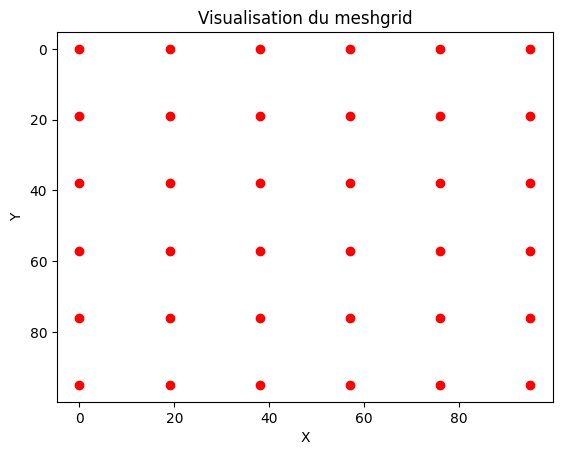

In [2]:
def grid(image, n_points_x, n_points_y):
    
    # Get the shape of the image
    height, width = image.shape
    
    # Compute the 1D vectors 
    X_vect = numpy.linspace(0, width-1, n_points_x)
    Y_vect = numpy.linspace(0, height-1, n_points_y)
    
    # Creating the meshgrid
    X, Y = numpy.meshgrid(X_vect, Y_vect)

    # Flatens the matrix to get a vector with cordinated
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    return X_flat, Y_flat, X, Y

# Exemple d'utilisation
image = cv2.imread('STL10/stl10_raw/test/airplane/airplane_test_001.png')

# Convertir l'image en niveaux de gris (important pour que la fonction grid fonctionne correctement)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

n_points_x = 6 # Nombre de points dans la direction x
n_points_y = 6  # Nombre de points dans la direction y
# Appel de la fonction
X_flat, Y_flat, X, Y = grid(image_gray, n_points_x, n_points_y)

# Affichage des premiers résultats pour visualiser la grille
print("Indices X :", X_flat[:10])
print("Indices Y :", Y_flat[:10])

plt.scatter(X, Y, c='r', marker='o')  # Utilisation de scatter pour visualiser la grille de points
plt.gca().invert_yaxis()  # Inverser l'axe Y pour correspondre aux coordonnées d'image
plt.title('Visualisation du meshgrid')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [3]:
def compute_hog_descriptors(image, X_flat, Y_flat, cell_size=4, num_bins=8, patch_size=16):
    """
    param image: image (grayscale)
    :param X_flat: 1D vector of x coordinates
    :param Y_flat: 1D vector of y coordinates
    :param cell_size: cell size (par défaut 4x4 pixels)
    :param num_bins: number of bins of each patch (8 by default)
    :return: 2D array containing hog descriptors for each point of the grid
    """
    hog_descriptors = []
    height, width = image.shape

    # Comoute the image gradient (using Sobel)
    gx = ndimage.sobel(image, axis=1)  # Gradient in x
    gy = ndimage.sobel(image, axis=0)  # Gradient in y

    # Compute the magnitude and direction of the gradient
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.arctan2(gy, gx)  

    # Put it in angle form
    direction = np.mod(direction, 2 * np.pi)


    # Pour chaque point de la grille, calculer le descripteur HOG
    for x, y in zip(X_flat, Y_flat):
        x, y = int(x), int(y)

        # Calculer à quel patch le point appartient
        x_patch_min = (x // patch_size) * patch_size
        y_patch_min = (y // patch_size) * patch_size

        # Fixer les limites du patch
        x_min = x_patch_min
        x_max = min(x_min + patch_size, width)
        y_min = y_patch_min
        y_max = min(y_min + patch_size, height)

        # Extraire la magnitude et la direction des gradients pour le patch de 16x16 pixels
        patch_magnitude = magnitude[y_min:y_max, x_min:x_max]
        patch_direction = direction[y_min:y_max, x_min:x_max]

        # Divide the patch into a 4x4 cells
        hog_vector = []
        
        # For each cell we compute the histogram
        for i in range(0, patch_magnitude.shape[0], cell_size):
            for j in range(0, patch_magnitude.shape[1], cell_size):
                # Extract the 4x4 cell from the patch
                cell_magnitude = patch_magnitude[i:i+cell_size, j:j+cell_size]
                cell_direction = patch_direction[i:i+cell_size, j:j+cell_size]

                # Create a histogram for that cell
                hist, _ = np.histogram(
                    cell_direction, bins=num_bins, range=(0, 2 * np.pi),
                    weights=cell_magnitude
                )

                # Append every histogram for each cell to the vector
                hog_vector.extend(hist)

        # Apend the histogram of this patch to the list of hog descriptor
        hog_descriptors.append(hog_vector)

    # Return the array of the HOG descriptor
    return np.array(hog_descriptors)

HOG_D = compute_hog_descriptors(image_gray, X_flat, Y_flat)



In [4]:
def display_hog_matrix(hog_descriptors):
    """
    Show informations of the hog descriptors
    
    :param hog_descriptors: 2D matrix of the hog descriptor (n_points x 128)
    """
    print("Shape of the HOG descriptors matrix:", hog_descriptors.shape)
    print("\nFirst 5 rows of the HOG descriptors matrix:\n", hog_descriptors[:5])  # Afficher les 5 premières lignes

# Example for an image
hog_descriptors = compute_hog_descriptors(image_gray, X_flat, Y_flat)
display_hog_matrix(hog_descriptors)


Shape of the HOG descriptors matrix: (36, 128)

First 5 rows of the HOG descriptors matrix:
 [[ 13.41   18.72    6.      0.      0.      0.      0.      0.      8.33
   28.9     2.      0.      0.      0.      0.      0.     12.33   37.1
    6.      0.      0.      0.      0.      0.     19.16    9.57   10.
    0.      0.      0.      0.      0.     33.8    11.55    8.      0.
    0.      0.      0.      0.     16.47   15.555   4.      0.      0.
    0.      0.      0.      9.16   30.94   10.      0.      0.      0.
    0.      0.     10.99   41.22    4.      0.      0.      0.      0.
    0.     12.46   30.22    2.      0.      0.      0.      0.      0.
   15.734  17.64    2.      0.      0.      0.      0.      0.     19.88
    8.82    8.      0.      0.      0.      0.      0.     17.03   16.78
    0.      0.      0.      0.      0.      0.     12.21   22.06    2.
    0.      0.      0.      0.      0.     11.984  34.6     0.      0.
    0.      0.      0.      0.     11.164   9.16

In [5]:
import numpy as np
from scipy.spatial.distance import cdist

def kmeans_clustering(hog_descriptors, K, max_iters=100, tol=1e-4):
    """
    Implements the K-means clustering algorithm to build a visual vocabulary.
    
    :param hog_descriptors: 2D array (n_samples x 128) containing HOG descriptors from all images
    :param K: Number of clusters (size of the visual vocabulary)
    :param max_iters: Maximum number of iterations for K-means (default 100)
    :param tol: Tolerance to stop the algorithm when centroids converge (default 1e-4)
    :return: 2D array of size K x 128 containing the final cluster centroids (visual words)
    """
    # Step 1: Randomly initialize the cluster centroids
    n_samples, n_features = hog_descriptors.shape
    centroids = hog_descriptors[np.random.permutation(n_samples)[:K]]  # Randomly select K centroids from data

    for iteration in range(max_iters):
        # Step 2: Assign each descriptor to the nearest centroid (using Euclidean distance)
        distances = cdist(hog_descriptors, centroids, 'euclidean')
        labels = np.argmin(distances, axis=1)  # Find the nearest centroid for each descriptor

        # Save the current centroids to check convergence later
        previous_centroids = centroids.copy()

        # Step 3: Update centroids by calculating the mean of all descriptors assigned to each centroid
        for k in range(K):
            points_in_cluster = hog_descriptors[labels == k]
            if len(points_in_cluster) > 0:
                centroids[k] = points_in_cluster.mean(axis=0)  # New centroid is the mean of all assigned points

        # Check for convergence (if centroids don't change much)
        centroid_shift = np.linalg.norm(centroids - previous_centroids, axis=1).max()
        if centroid_shift < tol:
            print(f"K-means converged after {iteration+1} iterations.")
            break

    return centroids

# Example usage with sample HOG descriptors
# Assume hog_descriptors is a 2D array (n_samples x 128) containing all HOG descriptors from training images

# Define the number of clusters (size of the visual vocabulary)
K = 50  # Example with 50 clusters

# Call the function to compute the centroids
vocabulary = kmeans_clustering(hog_descriptors, K)

# Print the shape of the resulting vocabulary (should be K x 128)
print("Visual vocabulary (centroids):", vocabulary.shape)

K-means converged after 1 iterations.
Visual vocabulary (centroids): (36, 128)
